In [ ]:
import random
import numpy as np
from lib.lib import oracle, simulate
from qiskit_ibm_runtime.fake_provider import *

max_val = 256
n = 10000
#S = np.random.randint(0, max_val, n)
#T = sum(random.choices(S, k=5))
S = [1,2,3,4,5,7,8,9]
T = 5
simulate(S,T, 3, backend=FakeMarrakesh(), noisy=True)

# Scalability

In [ ]:
from lib.lib import RotationAdd
from qiskit.circuit.library import QFTGate, grover_operator, MCMTGate, ZGate, HGate

def basis_gate_count_rotation_gate_worst_case(target_size) -> int:
    qc = QuantumCircuit(target_size + 1)
    adder = RotationAdd(2 ** target_size - 1, target_size)
    qc.append(adder, list(range(target_size)))
    return qiskit.transpile(qc, basis_gates=["h", "cx", "p"]).count_ops()

def rotation_gate_worst_case_depth(target_size) -> int:
    qc = QuantumCircuit(target_size + 1)
    adder = RotationAdd(2 ** target_size - 1, target_size)
    qc.append(adder, list(range(target_size + 1)))
    return qiskit.transpile(qc, basis_gates=["h", "cx", "p"]).depth()

def qft_worst_case_gate_count(target_size, inverse=False):
    qc = QuantumCircuit(target_size)
    if inverse:
        qc.append(QFTGate(target_size), list(range(target_size)))
    else:
        qc.append(QFTGate(target_size).inverse(), list(range(target_size)))

    return qiskit.transpile(qc, basis_gates=["h", "cx", "p"]).count_ops()

def qft_worst_case_depth(target_size, inverse=False):
    qc = QuantumCircuit(target_size)
    if inverse:
        qc.append(QFTGate(target_size), list(range(target_size)))
    else:
        qc.append(QFTGate(target_size).inverse(), list(range(target_size)))
    return qiskit.transpile(qc, basis_gates=["h", "cx", "p"]).depth()

def x_gate_depth():
    qc = QuantumCircuit(1)
    qc.x(0)
    return qiskit.transpile(qc, basis_gates=["h", "cx", "p"]).depth()

def x_gate_gate_count():
    qc = QuantumCircuit(1)
    qc.x(0)
    return qiskit.transpile(qc, basis_gates=["h", "cx", "p"]).count_ops()

def mcmt_depth(target_size):
    qc = QuantumCircuit(target_size)
    qc.append(MCMTGate(gate=ZGate(), num_ctrl_qubits=target_size-1, num_target_qubits=1), list(range(target_size)))
    return qiskit.transpile(qc, basis_gates=["h", "cx", "p"]).depth()

def mcmt_gate_count(target_size):
    qc = QuantumCircuit(target_size)
    qc.append(MCMTGate(gate=ZGate(), num_ctrl_qubits=target_size-1, num_target_qubits=1), list(range(target_size)))
    return qiskit.transpile(qc, basis_gates=["h", "cx", "p"]).depth()


def grover_diffusion_gate_count(data_size):
    qc = QuantumCircuit(data_size)
    grover_op = grover_operator(qc)
    return qiskit.transpile(grover_op, basis_gates=["h", "cx", "p"]).count_ops()

def grover_diffusion_depth(data_size):
    qc = QuantumCircuit(data_size)
    grover_op = grover_operator(qc)
    return qiskit.transpile(grover_op, basis_gates=["h", "cx", "p"]).depth()


In [ ]:
import random
import numpy as np
from lib.lib import oracle, simulate
from math import log2, ceil, sqrt

max_val = 256
for n in range(1,10000):
    data_register_size = n
    target_register_size_worst_case = ceil(log2(1 + n * max_val)) + 1
    qbit_count_worst_case = n + target_register_size_worst_case
    depth_worst_case = x_gate_depth()
    depth_worst_case += qft_worst_case_depth(target_register_size_worst_case)
    depth_worst_case += rotation_gate_worst_case_depth(target_register_size_worst_case) * data_register_size
    depth_worst_case += qft_worst_case_depth(target_register_size_worst_case, inverse=True)
    depth_worst_case += x_gate_depth()
    depth_worst_case *= 2 
    depth_worst_case += mcmt_depth(target_register_size_worst_case)
    depth_worst_case += grover_diffusion_depth(data_register_size)
    #depth_worst_case *= ceil(sqrt(2 ** data_register_size / 1) * 0.5)
    display(f"Qbits: {qbit_count_worst_case}, \t  Depth worst case: {depth_worst_case}")

In [ ]:
from lib.lib import groversearch
import pandas as pd

df = pd.DataFrame(columns=["qubits", "depth", "single_gate_count", "multi_gate_count"])

for n in range(1, 10000):
    orcl = groversearch([255] * n, 255*n, 1)
    orcl_t = qiskit.transpile(orcl, basis_gates=["h", "cx", "p"])
    gate_counts = orcl_t.count_ops()
    single_gate_count = gate_counts["h"] + gate_counts["p"]
    multi_gate_count = gate_counts["cx"]
    df.loc[n - 1] = [orcl_t.num_qubits, orcl_t.depth(), single_gate_count, multi_gate_count]
    display(f"QUbits {orcl_t.num_qubits}  Depth: {orcl_t.depth()}, Single gates: {single_gate_count} Multi gates: {multi_gate_count}")

df.to_csv("./scalibility.csv")

# Plots

In [4]:
import re

qubits = []
depths = []

with open("./test", "r") as f:
    for line in f:
        matches = re.findall(r'QUbits\s+(\d+)\s+Depth:\s+(\d+)', line)
        if matches:
            # matches will be a list of tuples, e.g., [('9', '333')]
            numbers = matches[0] # Get the first (and likely only) tuple
            qubits.append(int(numbers[0]))
            depths.append(int(numbers[1]))

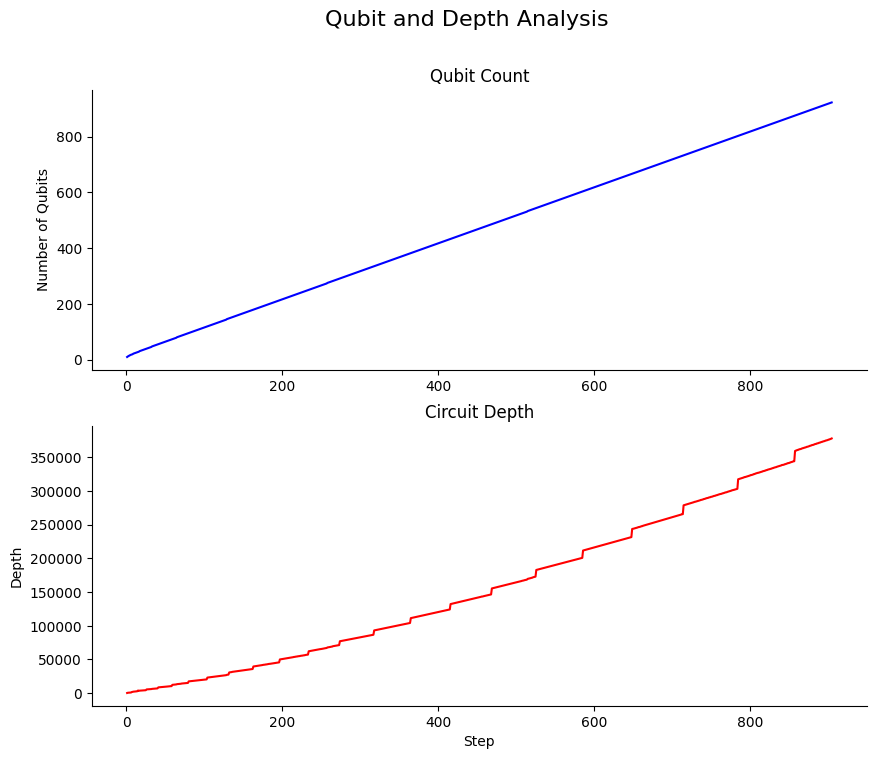

In [10]:
import matplotlib.pyplot as plt
import numpy as np 


x_values = range(1, len(qubits) + 1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

axes[0].plot(x_values, qubits, label='Qubits', color='blue')
axes[0].set_title('Qubit Count') 
axes[0].set_ylabel('Number of Qubits')

axes[1].plot(x_values, depths, label='Depth', color='red')
axes[1].set_title('Circuit Depth') 
axes[1].set_ylabel('Depth')
axes[1].set_xlabel('Step') 


fig.suptitle('Qubit and Depth Analysis', fontsize=16)

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


plt.show()